In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/intest/A1.h5ad")
sc.pp.filter_genes(spa_adata, min_cells=10)
# sc.pp.highly_variable_genes(spa_adata)
# spa_adata = spa_adata[:, spa_adata.var.highly_variable].copy()
spa_adata.obsm['spatial'] = spa_adata.obsm['spatial'][['x','y']].values
# sc.pp.normalize_total(spa_adata)
# sc.pp.log1p(spa_adata)
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv("../../output/locations/intest.csv", index=False)
rna_adata = sc.read_csv("../../data/scRNAseq/intest/GSE125970_raw_UMIcounts.txt", '\t', first_column_names=True).T.copy()
rna_adata.obs = pd.read_csv("../../data/scRNAseq/intest/GSE125970_cell_info.txt", header=0, delimiter='\t', index_col=0).loc[rna_adata.obs_names]
classes, ct_list = leiden_cluster(rna_adata)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata)
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()

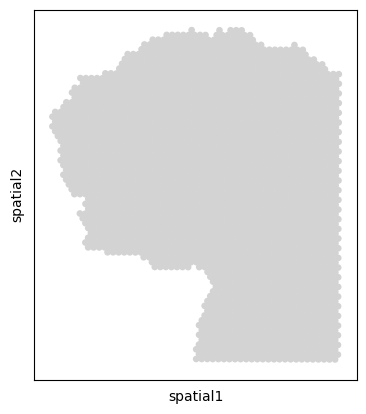

In [3]:
sc.pl.spatial(spa_adata, spot_size=100)

In [4]:
sq.gr.spatial_neighbors(spa_adata, n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    # n_perms=500,
    n_jobs=50,
)
# spa_adata = spa_adata[:, ~np.isnan(spa_adata.uns['moranI'].pval_norm_fdr_bh)].copy()
# spa_adata.uns['moranI'] = spa_adata.uns['moranI'].loc[spa_adata.var_names].copy()
# spa_adata = spa_adata[:, ~np.isnan(spa_adata.uns['moranI'].I)].copy()
# spa_adata.uns['moranI'] = spa_adata.uns['moranI'].loc[spa_adata.var_names].copy()
# spa_adata = spa_adata[:, spa_adata.uns['moranI'].I > 0].copy()
# spa_adata.uns['moranI'] = spa_adata.uns['moranI'].loc[spa_adata.var_names].copy()
rna_adata, spa_adata


(AnnData object with n_obs × n_vars = 14537 × 1749
     obs: 'Sample_ID', 'CellType', 'leiden'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'hvg',
 AnnData object with n_obs × n_vars = 2649 × 14444
     obs: 'Colonocytes', 'Crypt Top Colonocytes', 'Goblets', 'Undifferentiated', 'BEST4+/OTOP2+ Cell', 'Enteroendocrines', 'Glial', 'Stromal 2', 'Stromal 3', 'Stromal 1', 'Endothelial 1', 'Endothelial 2', 'Myofibroblasts', 'Stromal 4', 'Pericytes', 'ILCs', 'T-Cells', 'Macrophages&Monocytes', 'DC2', 'DC1', 'NK', 'Mast Cells', 'Cycling Cells', 'B-Cells', 'Plasma Cells'
     var: 'n_cells'
     uns: 'spatial_neighbors', 'moranI'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [5]:
spa_adata.uns['moranI']

,I,pval_norm,var_norm,pval_norm_fdr_bh
MT-CO1,0.622352,0.000000,0.000126,0.000000
MT-CO2,0.617618,0.000000,0.000126,0.000000
MT-CO3,0.612413,0.000000,0.000126,0.000000
CKB,0.610125,0.000000,0.000126,0.000000
TAGLN,0.592941,0.000000,0.000126,0.000000
...,...,...,...,...
PPP1R9B,-0.023107,0.021351,0.000126,0.054274
APBA3,-0.023336,0.020328,0.000126,0.052125
DHX8,-0.023863,0.018130,0.000126,0.047354
ZNF394,-0.024007,0.017566,0.000126,0.046099


In [6]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2649, 14444), (14537, 1749), (1414,))

In [7]:
spa_shared = spa_adata[:, raw_shared_gene].copy()
rna_shared = rna_adata[:, raw_shared_gene].copy()
raw_spatial_df  = pd.DataFrame(spa_shared.X, columns=spa_shared.var_names)
raw_scrna_df    = pd.DataFrame(rna_shared.X, columns=rna_shared.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2649, 1414), (14537, 1414), (1414,))

In [8]:
spa_shared.uns['moranI'].loc[raw_shared_gene]

,I,pval_norm,var_norm,pval_norm_fdr_bh
AAK1,0.000146,4.813856e-01,0.000126,4.891274e-01
AASS,0.032671,1.605716e-03,0.000126,5.752721e-03
AATK,0.003393,3.683465e-01,0.000126,4.306446e-01
ABCA10,0.010545,1.650523e-01,0.000126,2.716628e-01
ABCA5,0.076825,2.918887e-12,0.000126,2.909621e-11
...,...,...,...,...
ZNF701,0.005172,3.103514e-01,0.000126,3.998539e-01
ZNF821,-0.000866,4.826461e-01,0.000126,4.896607e-01
ZSCAN16-AS1,0.043960,3.855271e-05,0.000126,1.917546e-04
ZSWIM8,0.014145,9.768439e-02,0.000126,1.849945e-01


In [9]:
np.random.seed(42)
neg_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values >= 0.01], 50, replace=False)
pos_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values < 0.01], 50, replace=False)

train_gene = np.union1d(pos_genes, neg_genes)
test_gene = np.setdiff1d(raw_shared_gene, train_gene)
len(np.unique(train_gene)), len(test_gene)

(100, 1314)

In [10]:
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)

# for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
print(f"\n==========\nNumber of train genes: {len(train_gene)}, Number of test genes: {len(test_gene)}")

test_spatial_df = raw_spatial_df[test_gene]
spatial_df = raw_spatial_df[train_gene]
scrna_df   = raw_scrna_df

df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2500,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

df_transImpCls[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        n_epochs=2500,
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

df_transImp[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        mapping_mode='lowrank',
        n_epochs=2500,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

df_transImpClsSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        n_epochs=2500,
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_erf", top_k=100, verbose=False, random_seed=seed, device=device)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
np.median(corr_transImp_res), "(TransImp)", 
np.median(corr_transImpCls_res), "(TransImpCls)", 
np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
np.median(corr_res_stplus), "(stPlus)", 
np.median(corr_res_spaGE), "(spaGE)",
np.median(corr_res_tangram), "(Tangram)"
)


Number of train genes: 100, Number of test genes: 1314


[TransImp] Epoch: 2500/2500, loss: 0.440490, (IMP) 0.439113, (SPA) 1.0 x 0.001377: 100%|██████████| 2500/2500 [00:11<00:00, 225.31it/s]


Median correlation: 0.07468094787524956 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.993229, (IMP) 0.993229, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 452.64it/s]


Median correlation: 0.10030884273054233 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.427882, (IMP) 0.427882, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:07<00:00, 347.87it/s]


Median correlation: 0.08408201326618675 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 1.004267, (IMP) 0.999554, (SPA) 1.0 x 0.004713: 100%|██████████| 2500/2500 [00:09<00:00, 275.49it/s]


Median correlation: 0.08835905651047922 (TransImpClsSpa)
			0.06758422986015854 (stPlus)
			0.049866511547859094 (spaGE)


INFO:root:100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:100 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 100 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.240, KL reg: 0.157
Score: 0.400, KL reg: 0.002
Score: 0.403, KL reg: 0.002
Score: 0.403, KL reg: 0.002
Score: 0.403, KL reg: 0.002
Score: 0.404, KL reg: 0.002
Score: 0.404, KL reg: 0.002
Score: 0.404, KL reg: 0.002
Score: 0.404, KL reg: 0.002


INFO:root:Saving results..


Score: 0.404, KL reg: 0.002
			0.10885189413009233 (Tangram)
0.07468094787524956 (TransImpSpa) 0.08408201326618675 (TransImp) 0.10030884273054233 (TransImpCls) 0.08835905651047922 (TransImpClsSpa) 0.06758422986015854 (stPlus) 0.049866511547859094 (spaGE) 0.10885189413009233 (Tangram)


In [11]:
df_transImp.to_csv('../../output/intestext_singlecell_transImpute.csv')
df_transImpSpa.to_csv('../../output/intestext_singlecell_transImpSpa.csv')
df_transImpCls.to_csv('../../output/intestext_singlecell_transImpCls.csv')
df_transImpClsSpa.to_csv('../../output/intestext_singlecell_transImpClsSpa.csv')
df_spaGE_res.to_csv('../../output/intestext_singlecell_spaGE.csv')
df_stplus_res.to_csv('../../output/intestext_singlecell_stPlus.csv')
df_tangram_res.to_csv('../../output/intestext_singlecell_Tangram.csv')
test_spatial_df.to_csv('../../output/intestext_singlecell_truth.csv')

In [12]:
dict_df = {
        "TransImp":df_transImp[test_gene], 
           "TransImpSpa":df_transImpSpa[test_gene], 
           "TransImpCls":df_transImpCls[test_gene],
           "TransImpClsSpa":df_transImpClsSpa[test_gene],
           "spaGE": df_spaGE_res[test_gene], 
           "stPlus": df_stplus_res[test_gene], 
           "Tangram":df_tangram_res[test_gene]
        }

dict_adata = {name: compute_autocorr(spa_shared[:, test_gene].copy(), df) for name, df in dict_df.items()}


In [13]:
# sq.gr.spatial_autocorr(
#     dict_adata["TransImpSpa"],
#     n_perms=500, n_jobs=50,
# )
# dict_adata["TransImpSpa"].uns['moranI']

In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings



with open("../../output/intestext_small_train_genes.pkl", 'wb') as outfile:
    pickle.dump((train_gene, test_gene), outfile)

warnings.filterwarnings('ignore')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
eval_res_path = "../../output/intestext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01


In [15]:
spa_shared

AnnData object with n_obs × n_vars = 2649 × 1414
    obs: 'Colonocytes', 'Crypt Top Colonocytes', 'Goblets', 'Undifferentiated', 'BEST4+/OTOP2+ Cell', 'Enteroendocrines', 'Glial', 'Stromal 2', 'Stromal 3', 'Stromal 1', 'Endothelial 1', 'Endothelial 2', 'Myofibroblasts', 'Stromal 4', 'Pericytes', 'ILCs', 'T-Cells', 'Macrophages&Monocytes', 'DC2', 'DC1', 'NK', 'Mast Cells', 'Cycling Cells', 'B-Cells', 'Plasma Cells'
    var: 'n_cells'
    uns: 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [16]:
if is_reeval:
    spa_adata = spa_shared[:, test_gene].copy()
    df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'is_sig':{}, 'I':{}, 'spatialDE_stats':{}, 'spatialDE_qvals':{}}
    for method  in tqdm(['stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']):
   
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        imp_adata = dict_adata[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=50,
            # n_perms=500,
            mode='moran',
        )

        if not is_reeval:
            continue

       
        is_sig = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['is_sig'][method] = pd.Series(is_sig, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


In [17]:
np.unique(spa_adata.uns['moranI'].pval_norm_fdr_bh < .01, return_counts=True)

(array([False,  True]), array([10093,  4351]))

In [18]:

df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_issig     = pd.DataFrame(dict(sorted(eval_res['is_sig'].items())))
df_spatialDE_stats = pd.DataFrame(dict(sorted(eval_res['spatialDE_stats'].items())))
df_spatialDE_pvals = pd.DataFrame(dict(sorted(eval_res['spatialDE_qvals'].items())))

df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_issig['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_issig

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
AAK1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.891274e-01
AASS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.752721e-03
AATK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.306446e-01
ABCA10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.716628e-01
ABCA5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.909621e-11
...,...,...,...,...,...,...,...,...
ZNF701,0.094962,0.402686,0.177361,0.251540,0.349644,0.298111,0.388501,3.998539e-01
ZNF821,0.172931,0.416674,0.183554,0.241851,0.205328,0.258428,0.354378,4.896607e-01
ZSCAN16-AS1,0.498817,0.433143,0.185680,0.234078,0.155067,0.243131,0.350800,1.917546e-04
ZSWIM8,0.448962,0.452970,0.279684,0.155118,0.145206,0.219351,0.302054,1.849945e-01


(Tangram) Valid genes: 1314/1314
Tangram
FPR: 0.983687
(TransImp) Valid genes: 1314/1314
TransImp
FPR: 0.944535
(TransImpSpa) Valid genes: 1314/1314
TransImpSpa
FPR: 0.905383
(spaGE) Valid genes: 1314/1314
spaGE
FPR: 0.841762
(stPlus) Valid genes: 1314/1314
stPlus
FPR: 0.938010


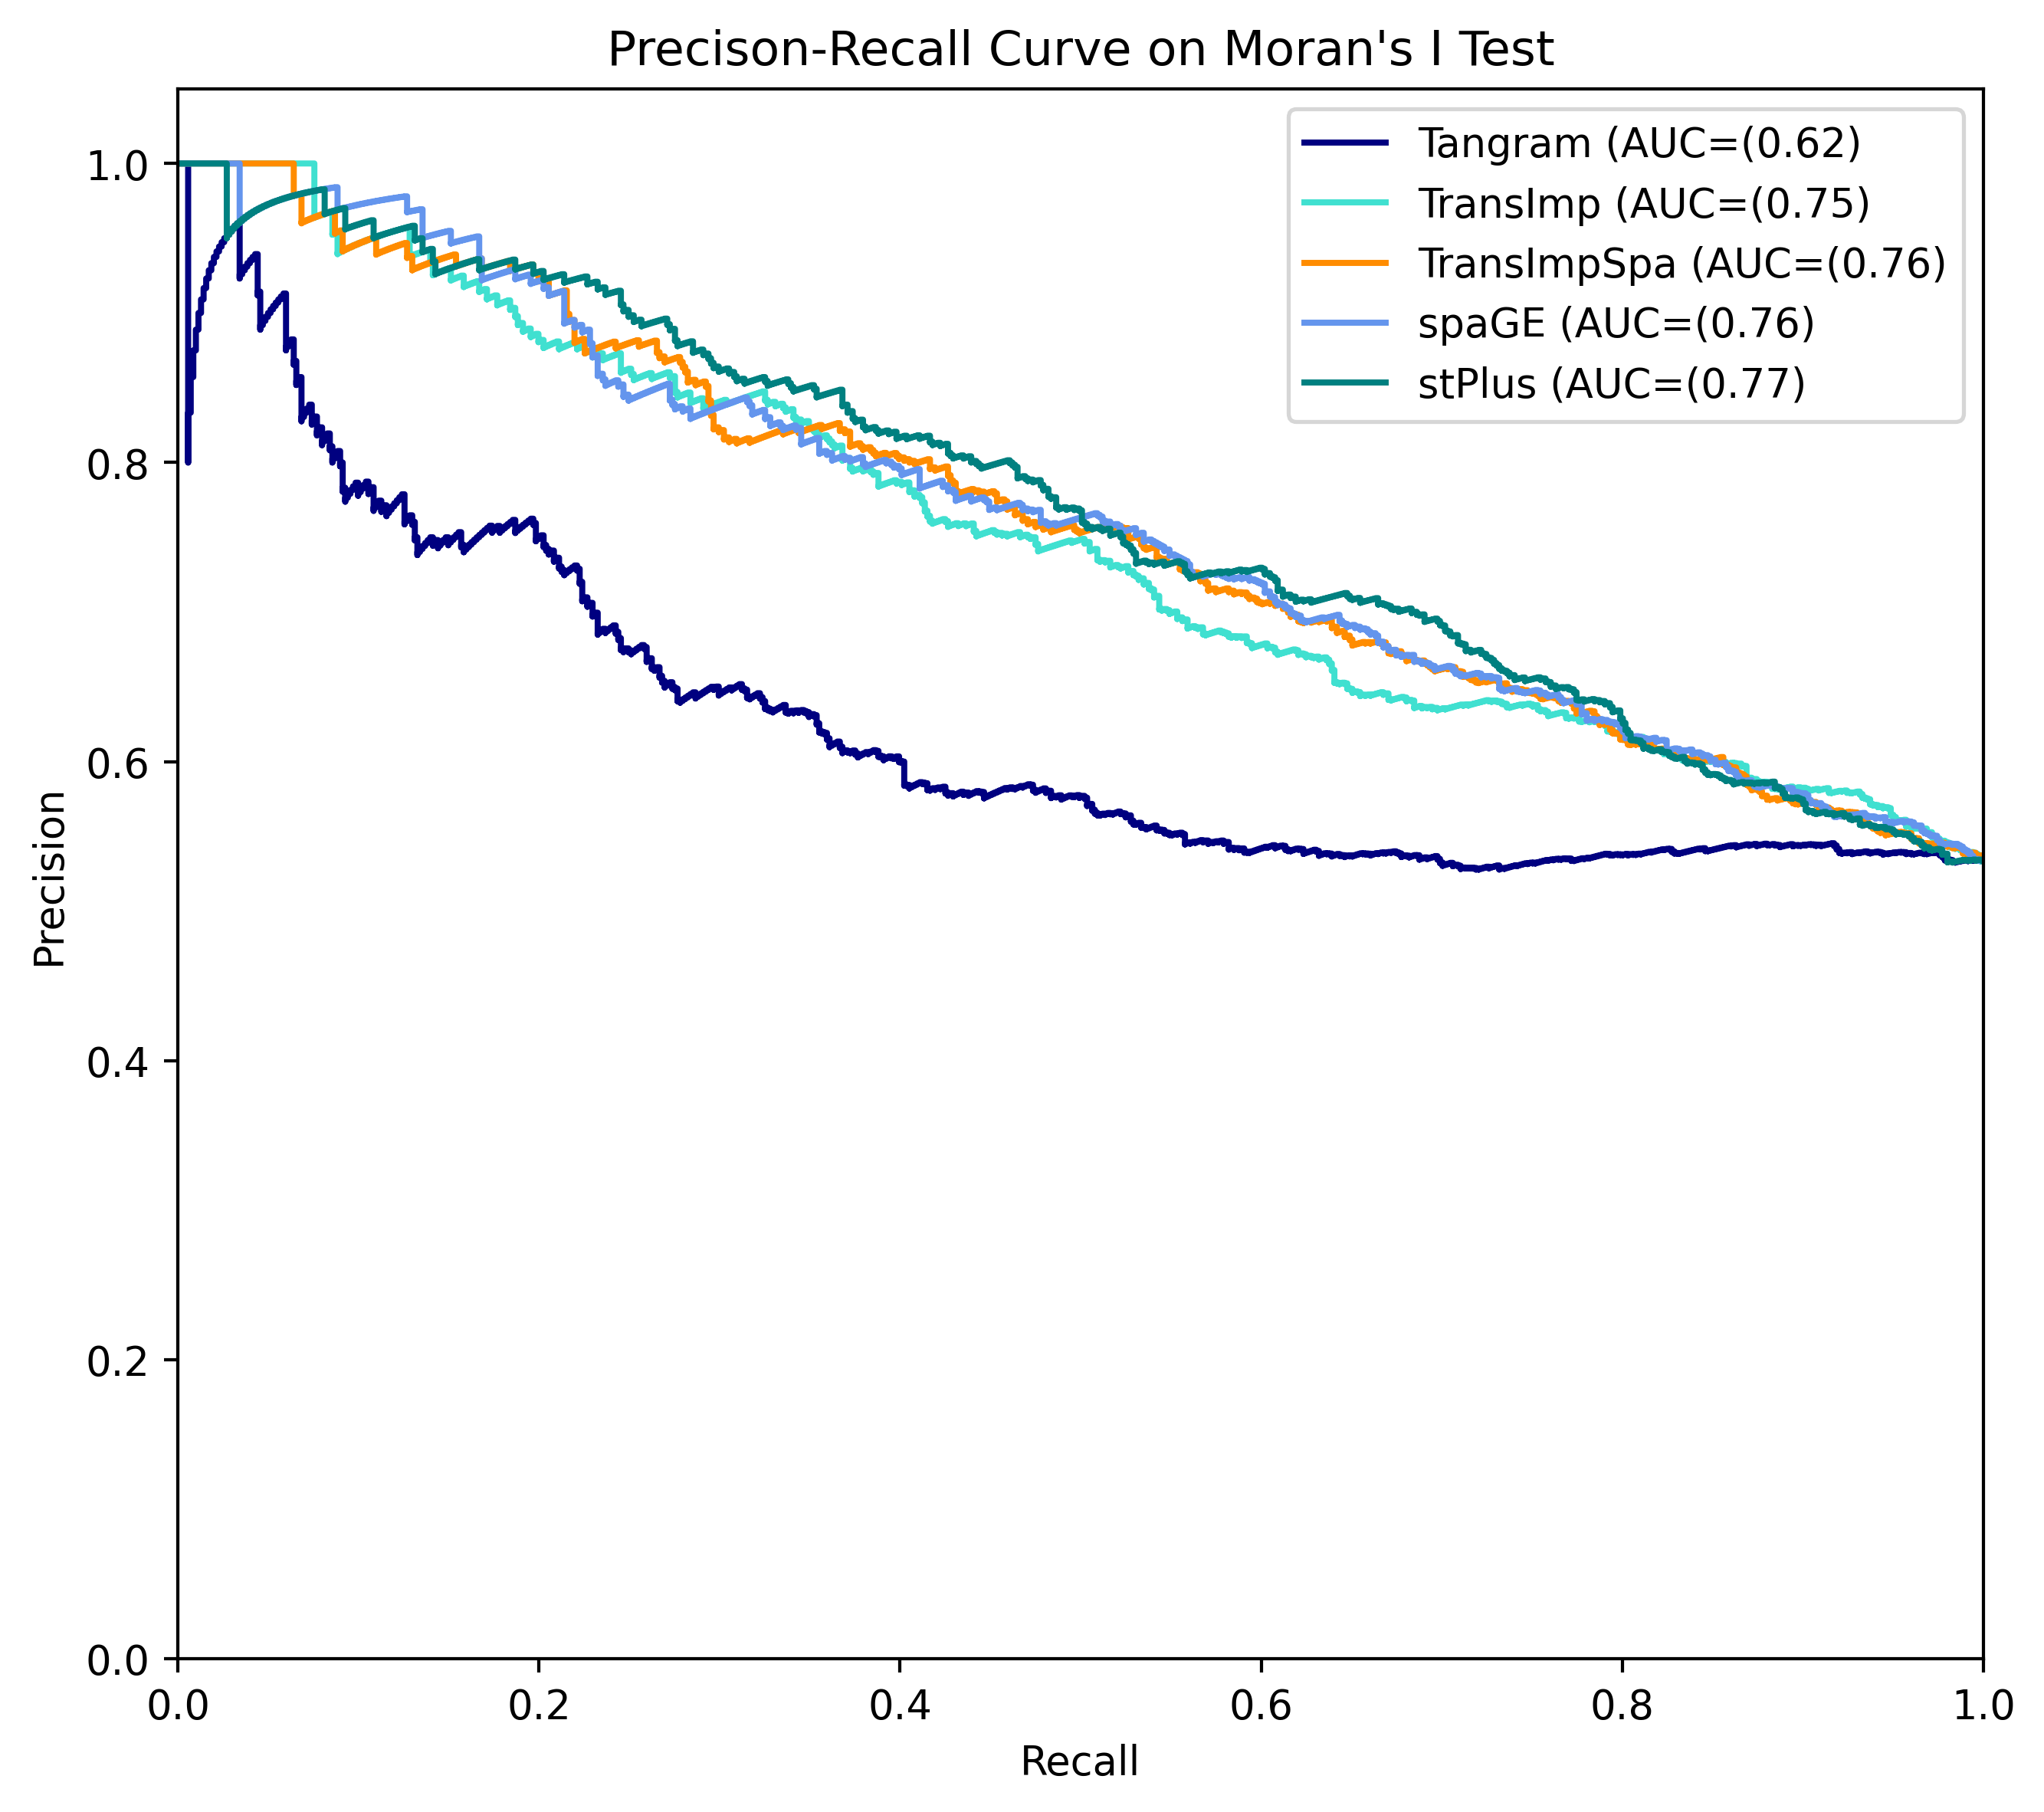

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    # sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred

    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(y < thred, I):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 1314/1314
Tangram
FPR: 0.983687
(TransImp) Valid genes: 1314/1314
TransImp
FPR: 0.944535
(TransImpSpa) Valid genes: 1314/1314
TransImpSpa
FPR: 0.905383
(spaGE) Valid genes: 1314/1314
spaGE
FPR: 0.841762
(stPlus) Valid genes: 1314/1314
stPlus
FPR: 0.938010


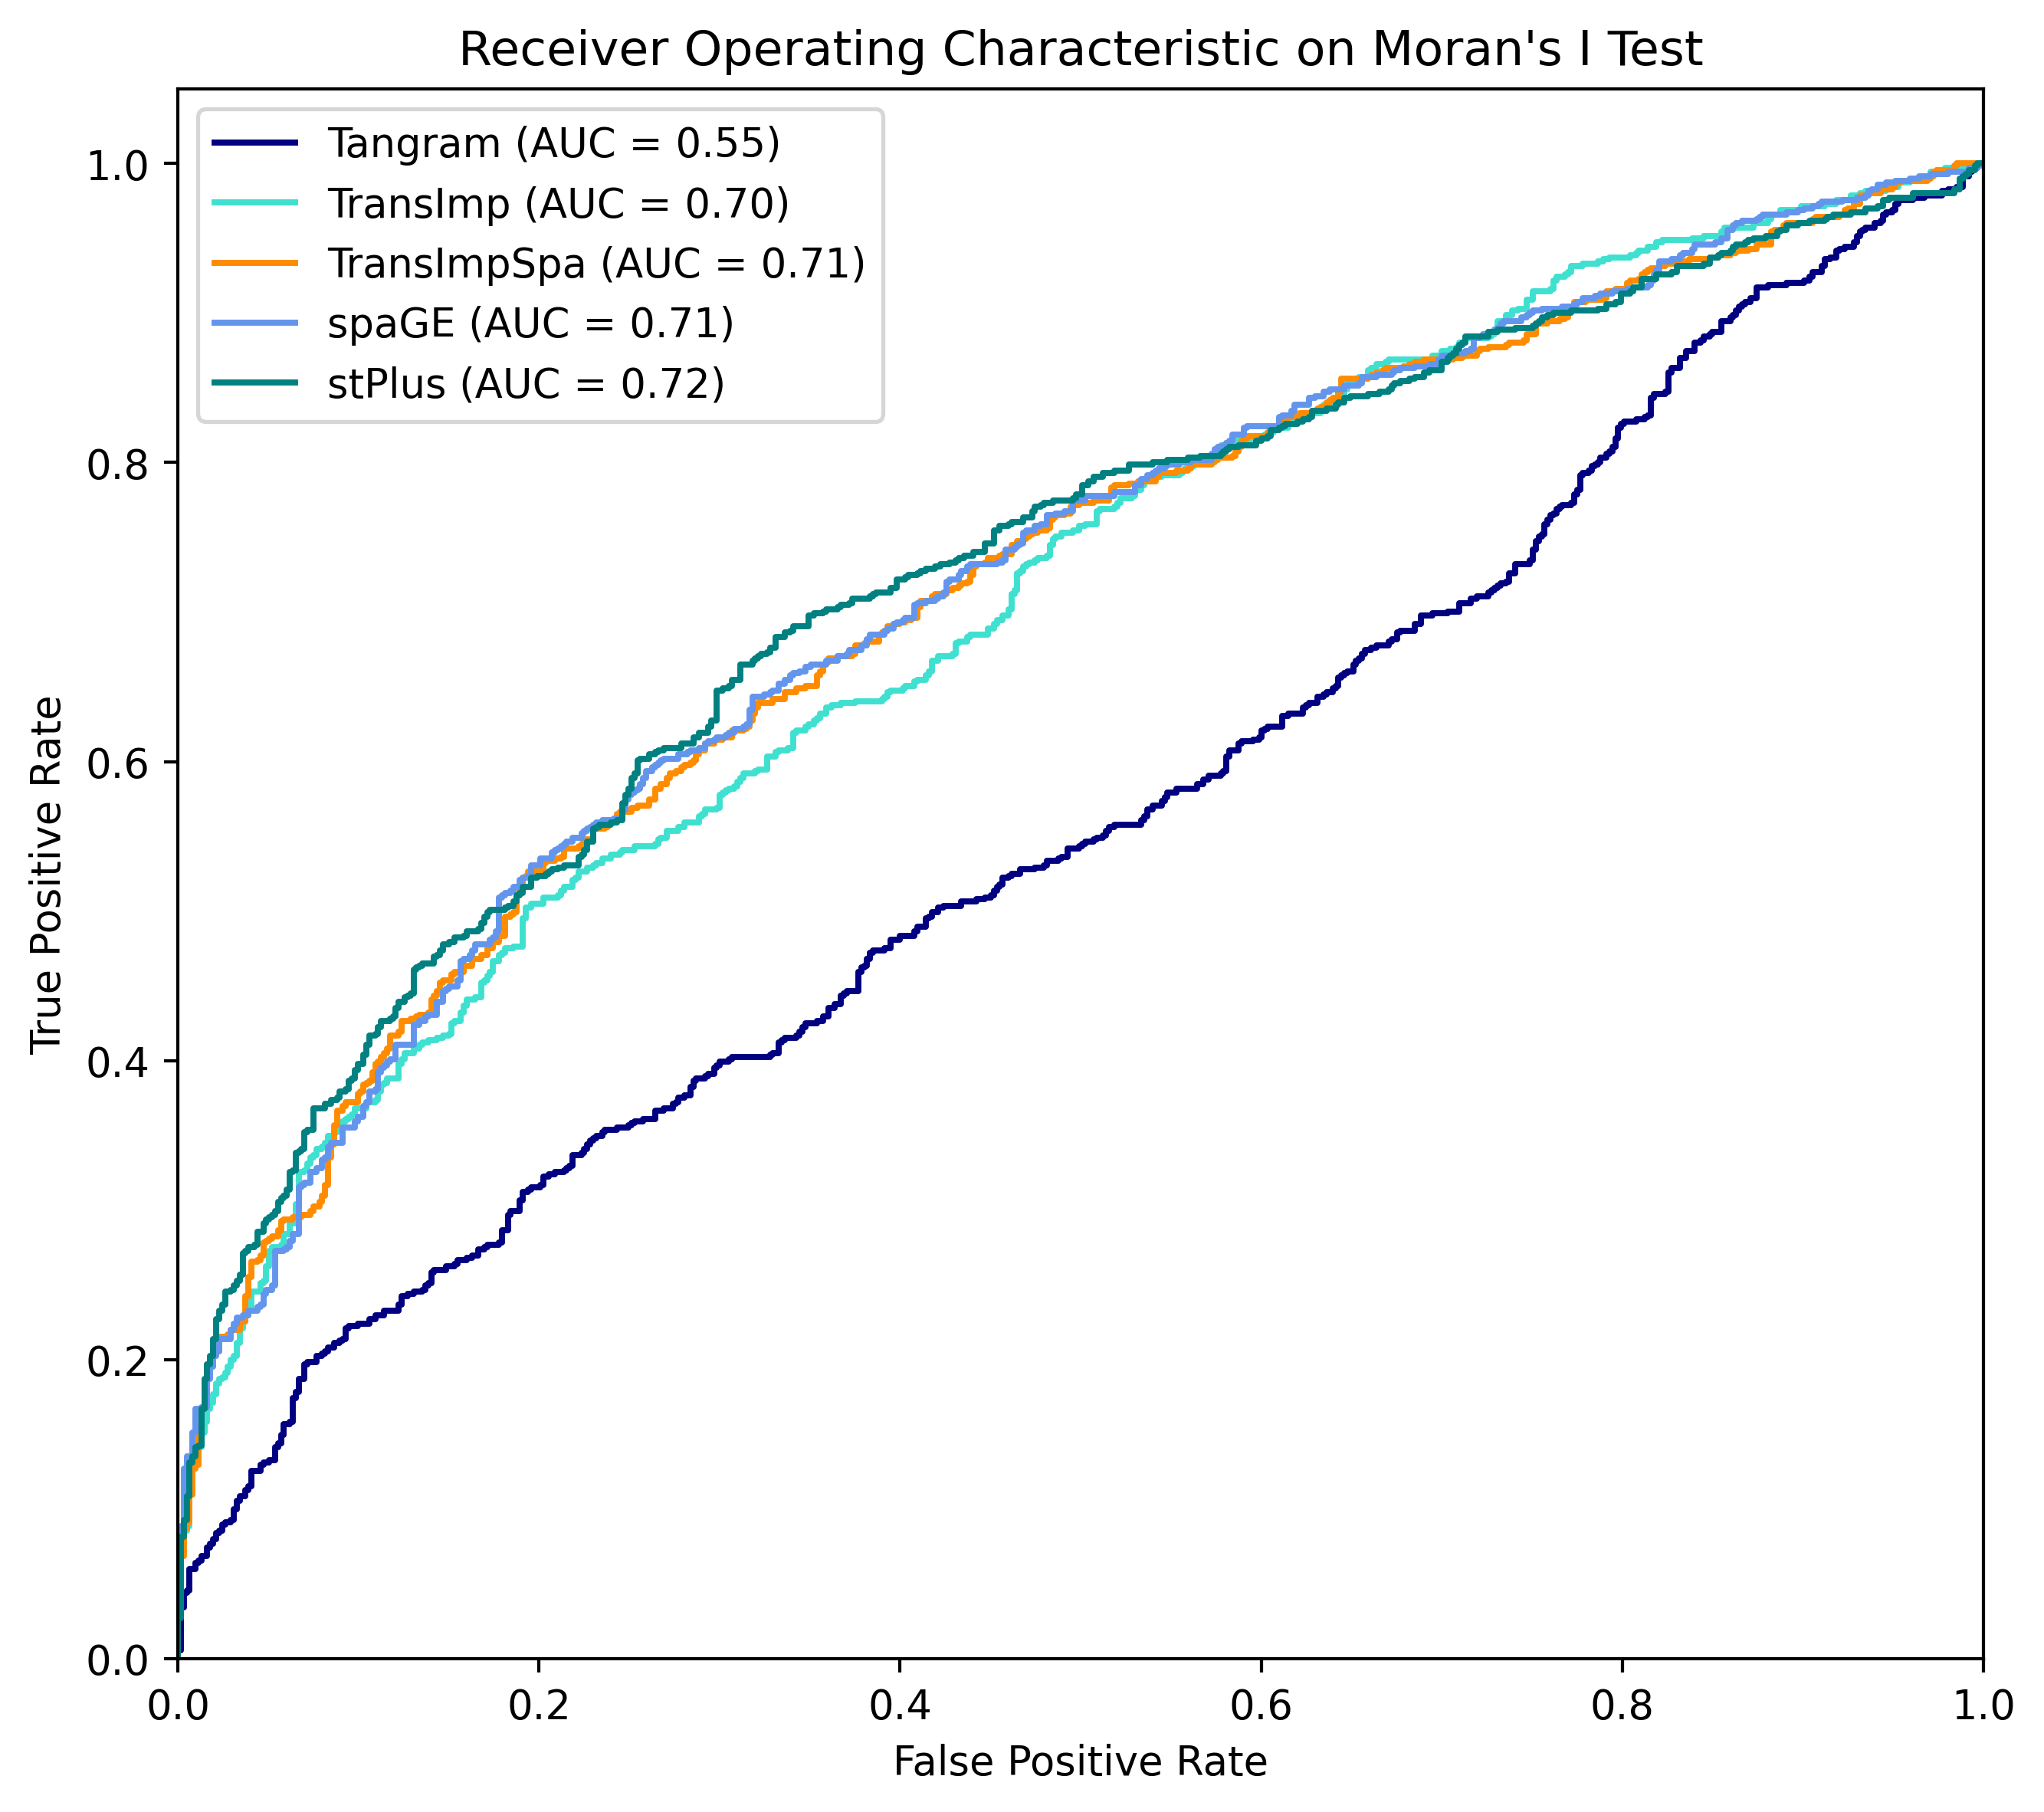

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [20]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    # sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
       
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(y < thred, I):.2f})", color=color[idx])
    


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 1139/1314
Tangram
FPR: 0.988584
prec: 0.6171529619805481, recl: 0.9957203994293866,  F1: 0.7620087336244541
(TransImp) Valid genes: 1139/1314
TransImp
FPR: 0.958904
prec: 0.615032080659945, recl: 0.9572039942938659,  F1: 0.7488839285714285
(TransImpCls) Valid genes: 1139/1314
TransImpCls
FPR: 0.965753
prec: 0.6168478260869565, recl: 0.9714693295292439,  F1: 0.7545706371191135
(TransImpClsSpa) Valid genes: 1139/1314
TransImpClsSpa
FPR: 0.810502
prec: 0.6085997794928335, recl: 0.7874465049928673,  F1: 0.6865671641791044
(TransImpSpa) Valid genes: 1139/1314
TransImpSpa
FPR: 0.917808
prec: 0.6138328530259366, recl: 0.9115549215406562,  F1: 0.7336394948335246
(spaGE) Valid genes: 1139/1314
spaGE
FPR: 0.860731
prec: 0.6093264248704663, recl: 0.8388017118402282,  F1: 0.7058823529411765
(stPlus) Valid genes: 1139/1314
stPlus
FPR: 0.952055
prec: 0.6160220994475138, recl: 0.9543509272467903,  F1: 0.748740906547286


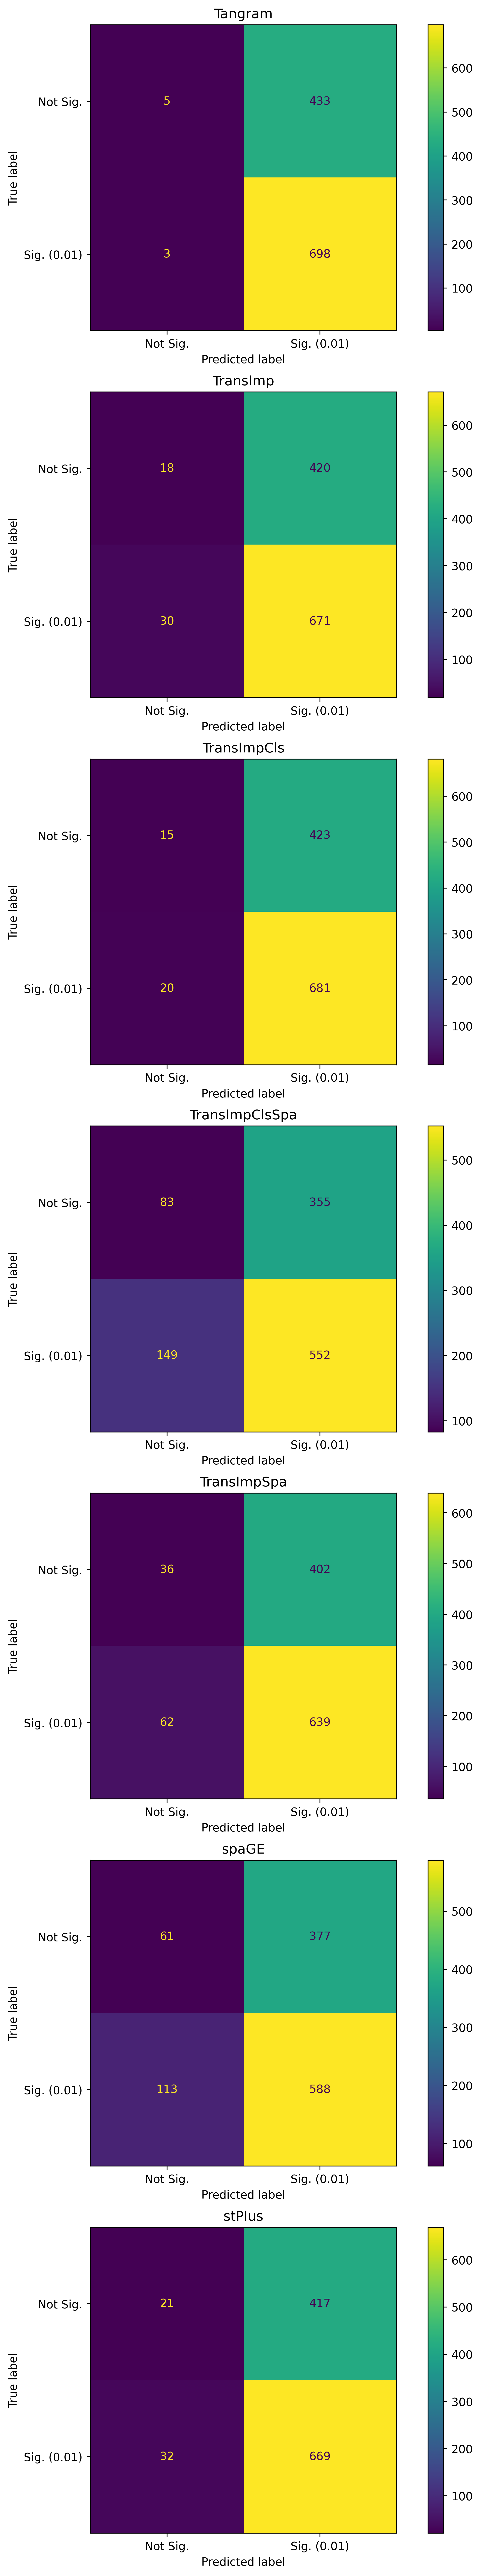

In [21]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

## SparkX

In [22]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r intest

[1] "transImpute"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2649 
## number of total genes: 1314 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "transImpSpa"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2649 
## number of total genes: 1314 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
##

In [23]:
methods = ["truth", "transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus", "Tangram"]
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None
name_mapping = {"transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
for md in methods:
    df = pd.read_csv(f"../../output/sparkx_intest_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    if md in name_mapping:
        md = name_mapping[md]
    
    diff_genes = np.setdiff1d(ca_genes, df.index.values)
    if len(diff_genes) > 0:
        df = df.append(pd.DataFrame(np.ones((len(diff_genes), df.shape[1])), index=diff_genes, columns=df.columns))
        
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

(                    truth      TransImp   TransImpSpa   TransImpCls  \
 AAK1         1.599128e-02  4.571732e-84  4.967305e-63  2.200076e-80   
 AASS         9.889047e-01  7.627694e-04  1.125731e-02  9.392487e-14   
 AATK         1.157804e-02  6.283919e-27  5.434209e-12  1.707885e-17   
 ABCA10       1.733596e-01  6.251871e-36  3.210381e-21  1.516113e-80   
 ABCA5        5.013970e-21  1.516664e-72  1.047593e-51  5.826351e-80   
 ...                   ...           ...           ...           ...   
 ZNF701       3.227768e-01  7.760903e-12  1.643130e-14  5.066009e-38   
 ZNF821       3.514562e-01  8.990375e-06  1.225386e-03  2.141069e-71   
 ZSCAN16.AS1  3.803926e-02  9.122630e-05  2.945109e-06  2.003231e-09   
 ZSWIM8       2.988999e-03  1.270254e-19  1.241651e-17  8.025959e-42   
 ZWINT        7.068722e-02  1.986054e-03  2.283331e-01  3.805845e-13   
 
              TransImpClsSpa         spaGE        stPlus       Tangram  
 AAK1           8.640883e-42  2.741580e-49  1.815109e-82  8.5

(Tangram) Valid genes: 1314/1314
Tangram
FPR: 0.923382
(TransImp) Valid genes: 1314/1314
TransImp
FPR: 0.737120
(TransImpSpa) Valid genes: 1314/1314
TransImpSpa
FPR: 0.659181
(spaGE) Valid genes: 1314/1314
spaGE
FPR: 0.701453
(stPlus) Valid genes: 1314/1314
stPlus
FPR: 0.805812


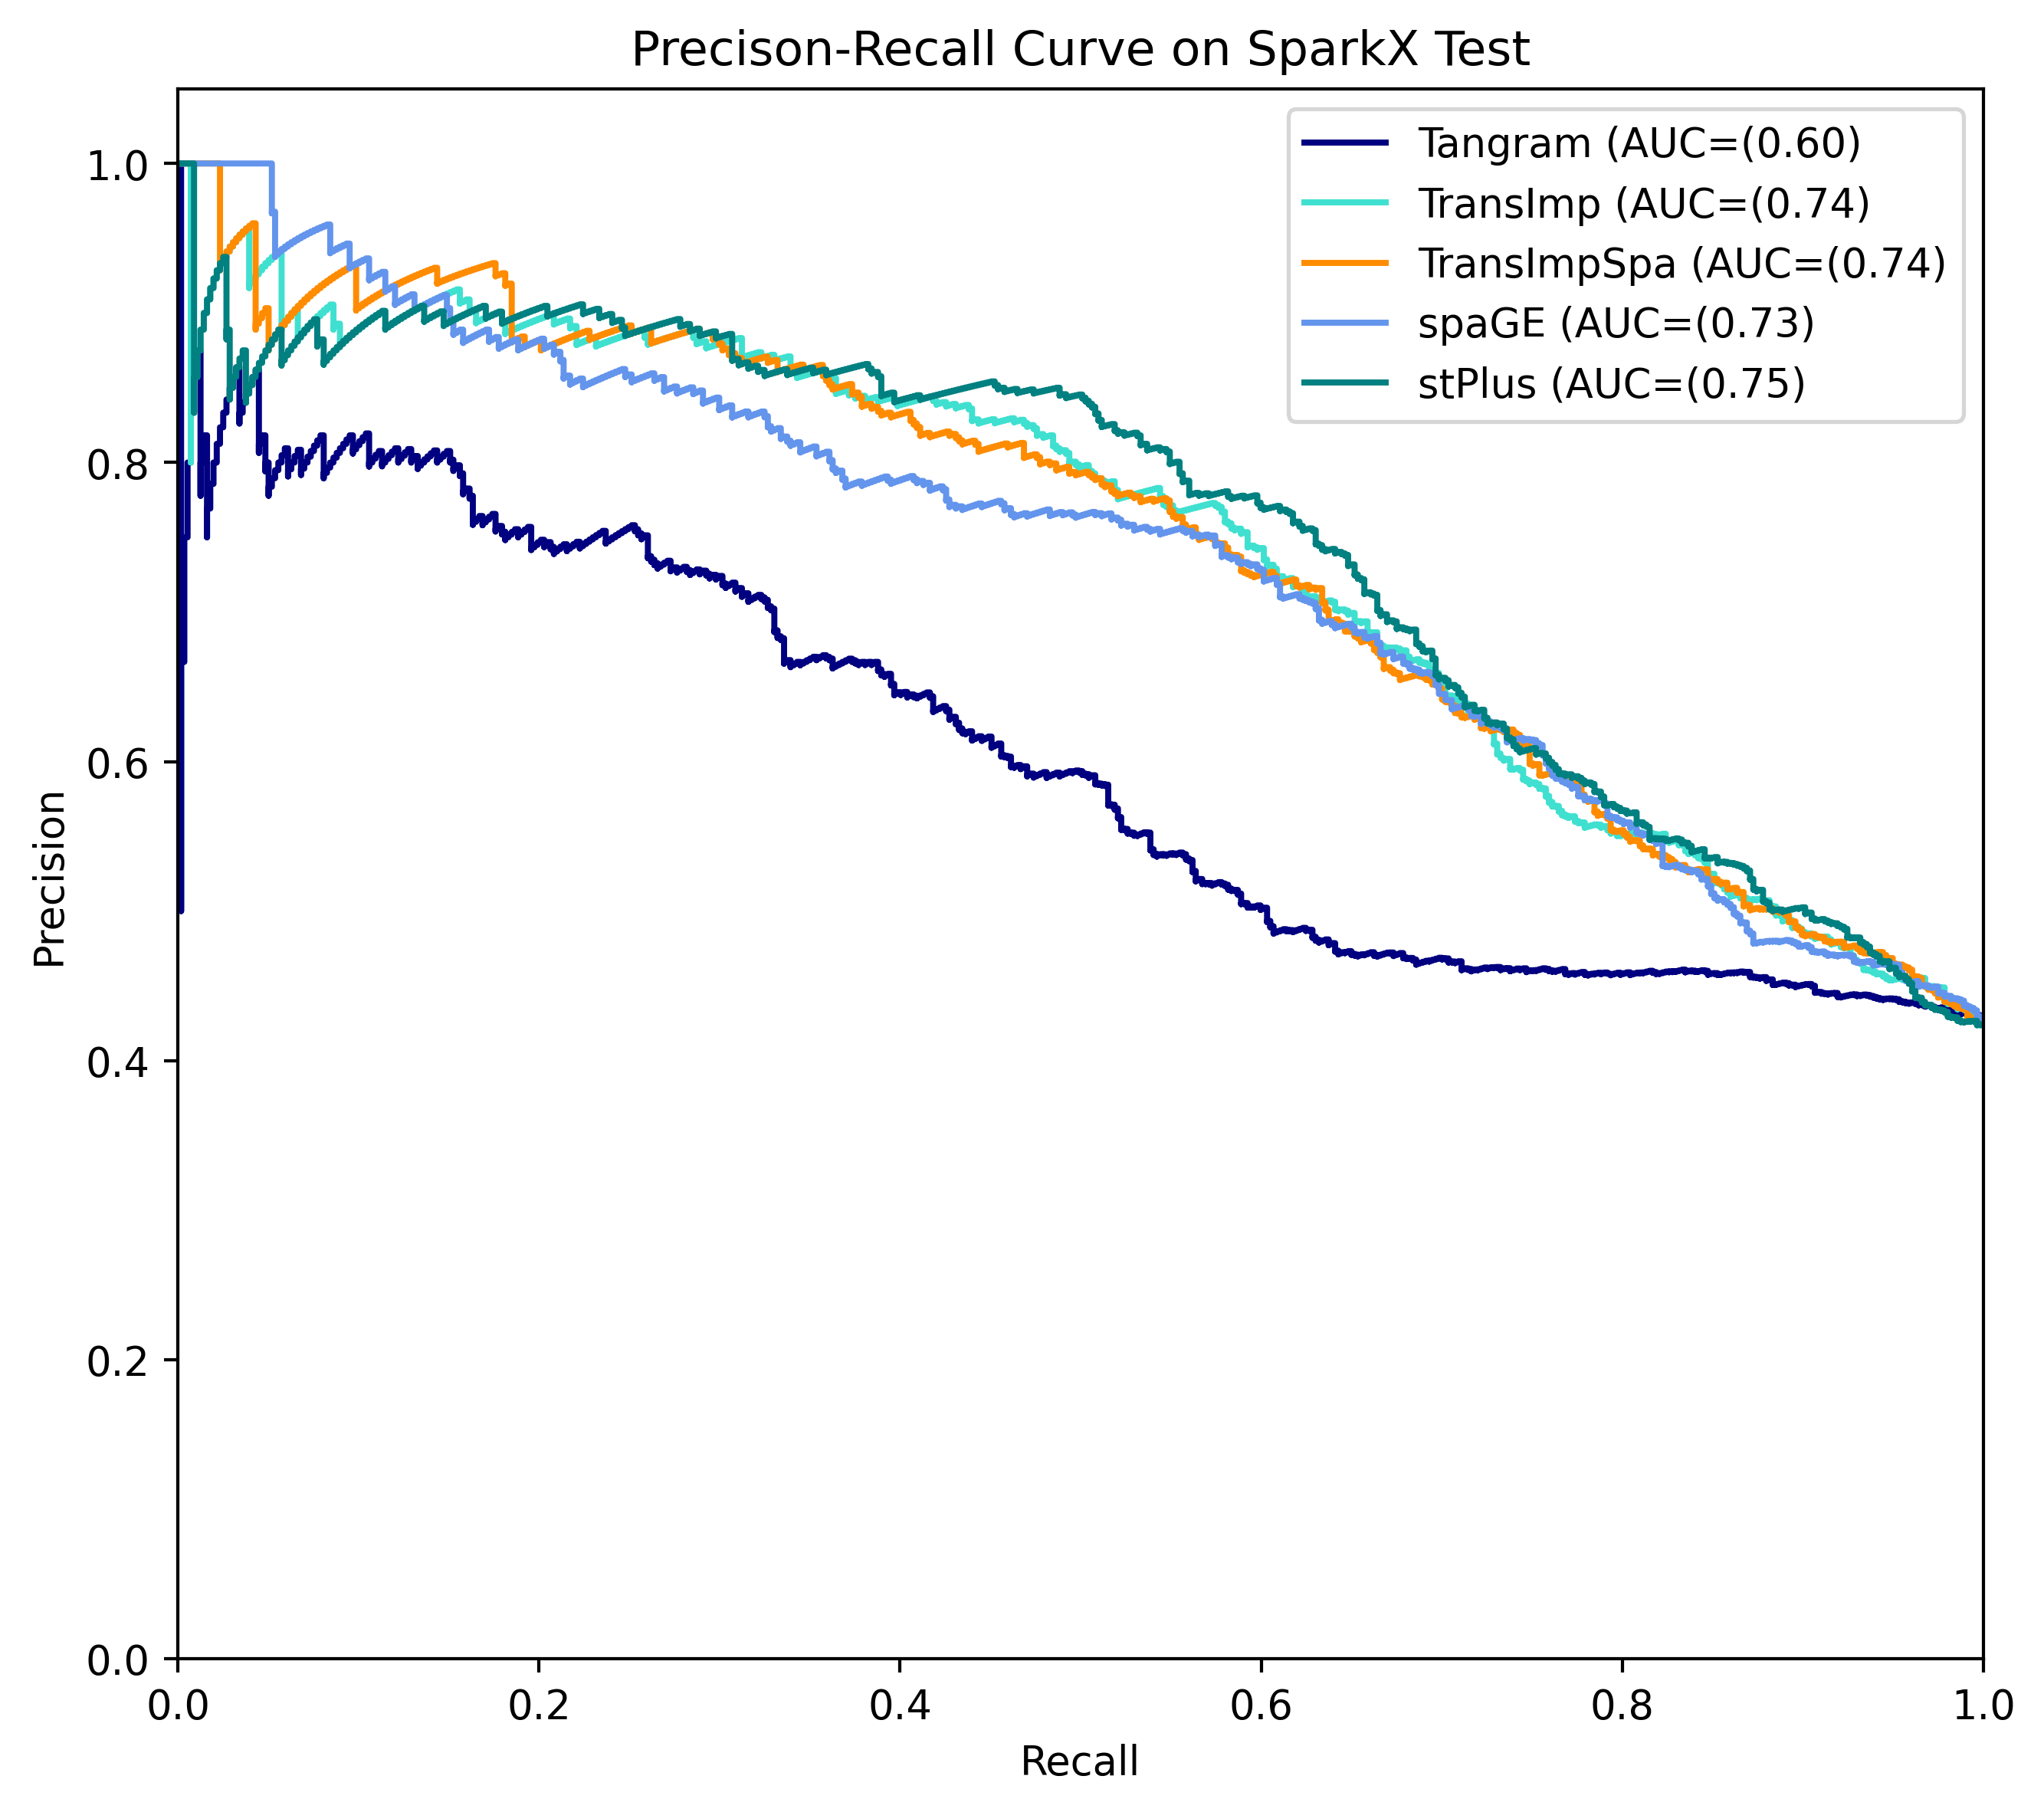

In [24]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_adjpvals[method][sel].values
    # score = 1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_cmbpvals[method][sel].values + 1e-100)
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    
        
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
        
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 1314/1314
Tangram
FPR: 0.923382
(TransImp) Valid genes: 1314/1314
TransImp
FPR: 0.737120
(TransImpSpa) Valid genes: 1314/1314
TransImpSpa
FPR: 0.659181
(spaGE) Valid genes: 1314/1314
spaGE
FPR: 0.701453
(stPlus) Valid genes: 1314/1314
stPlus
FPR: 0.805812


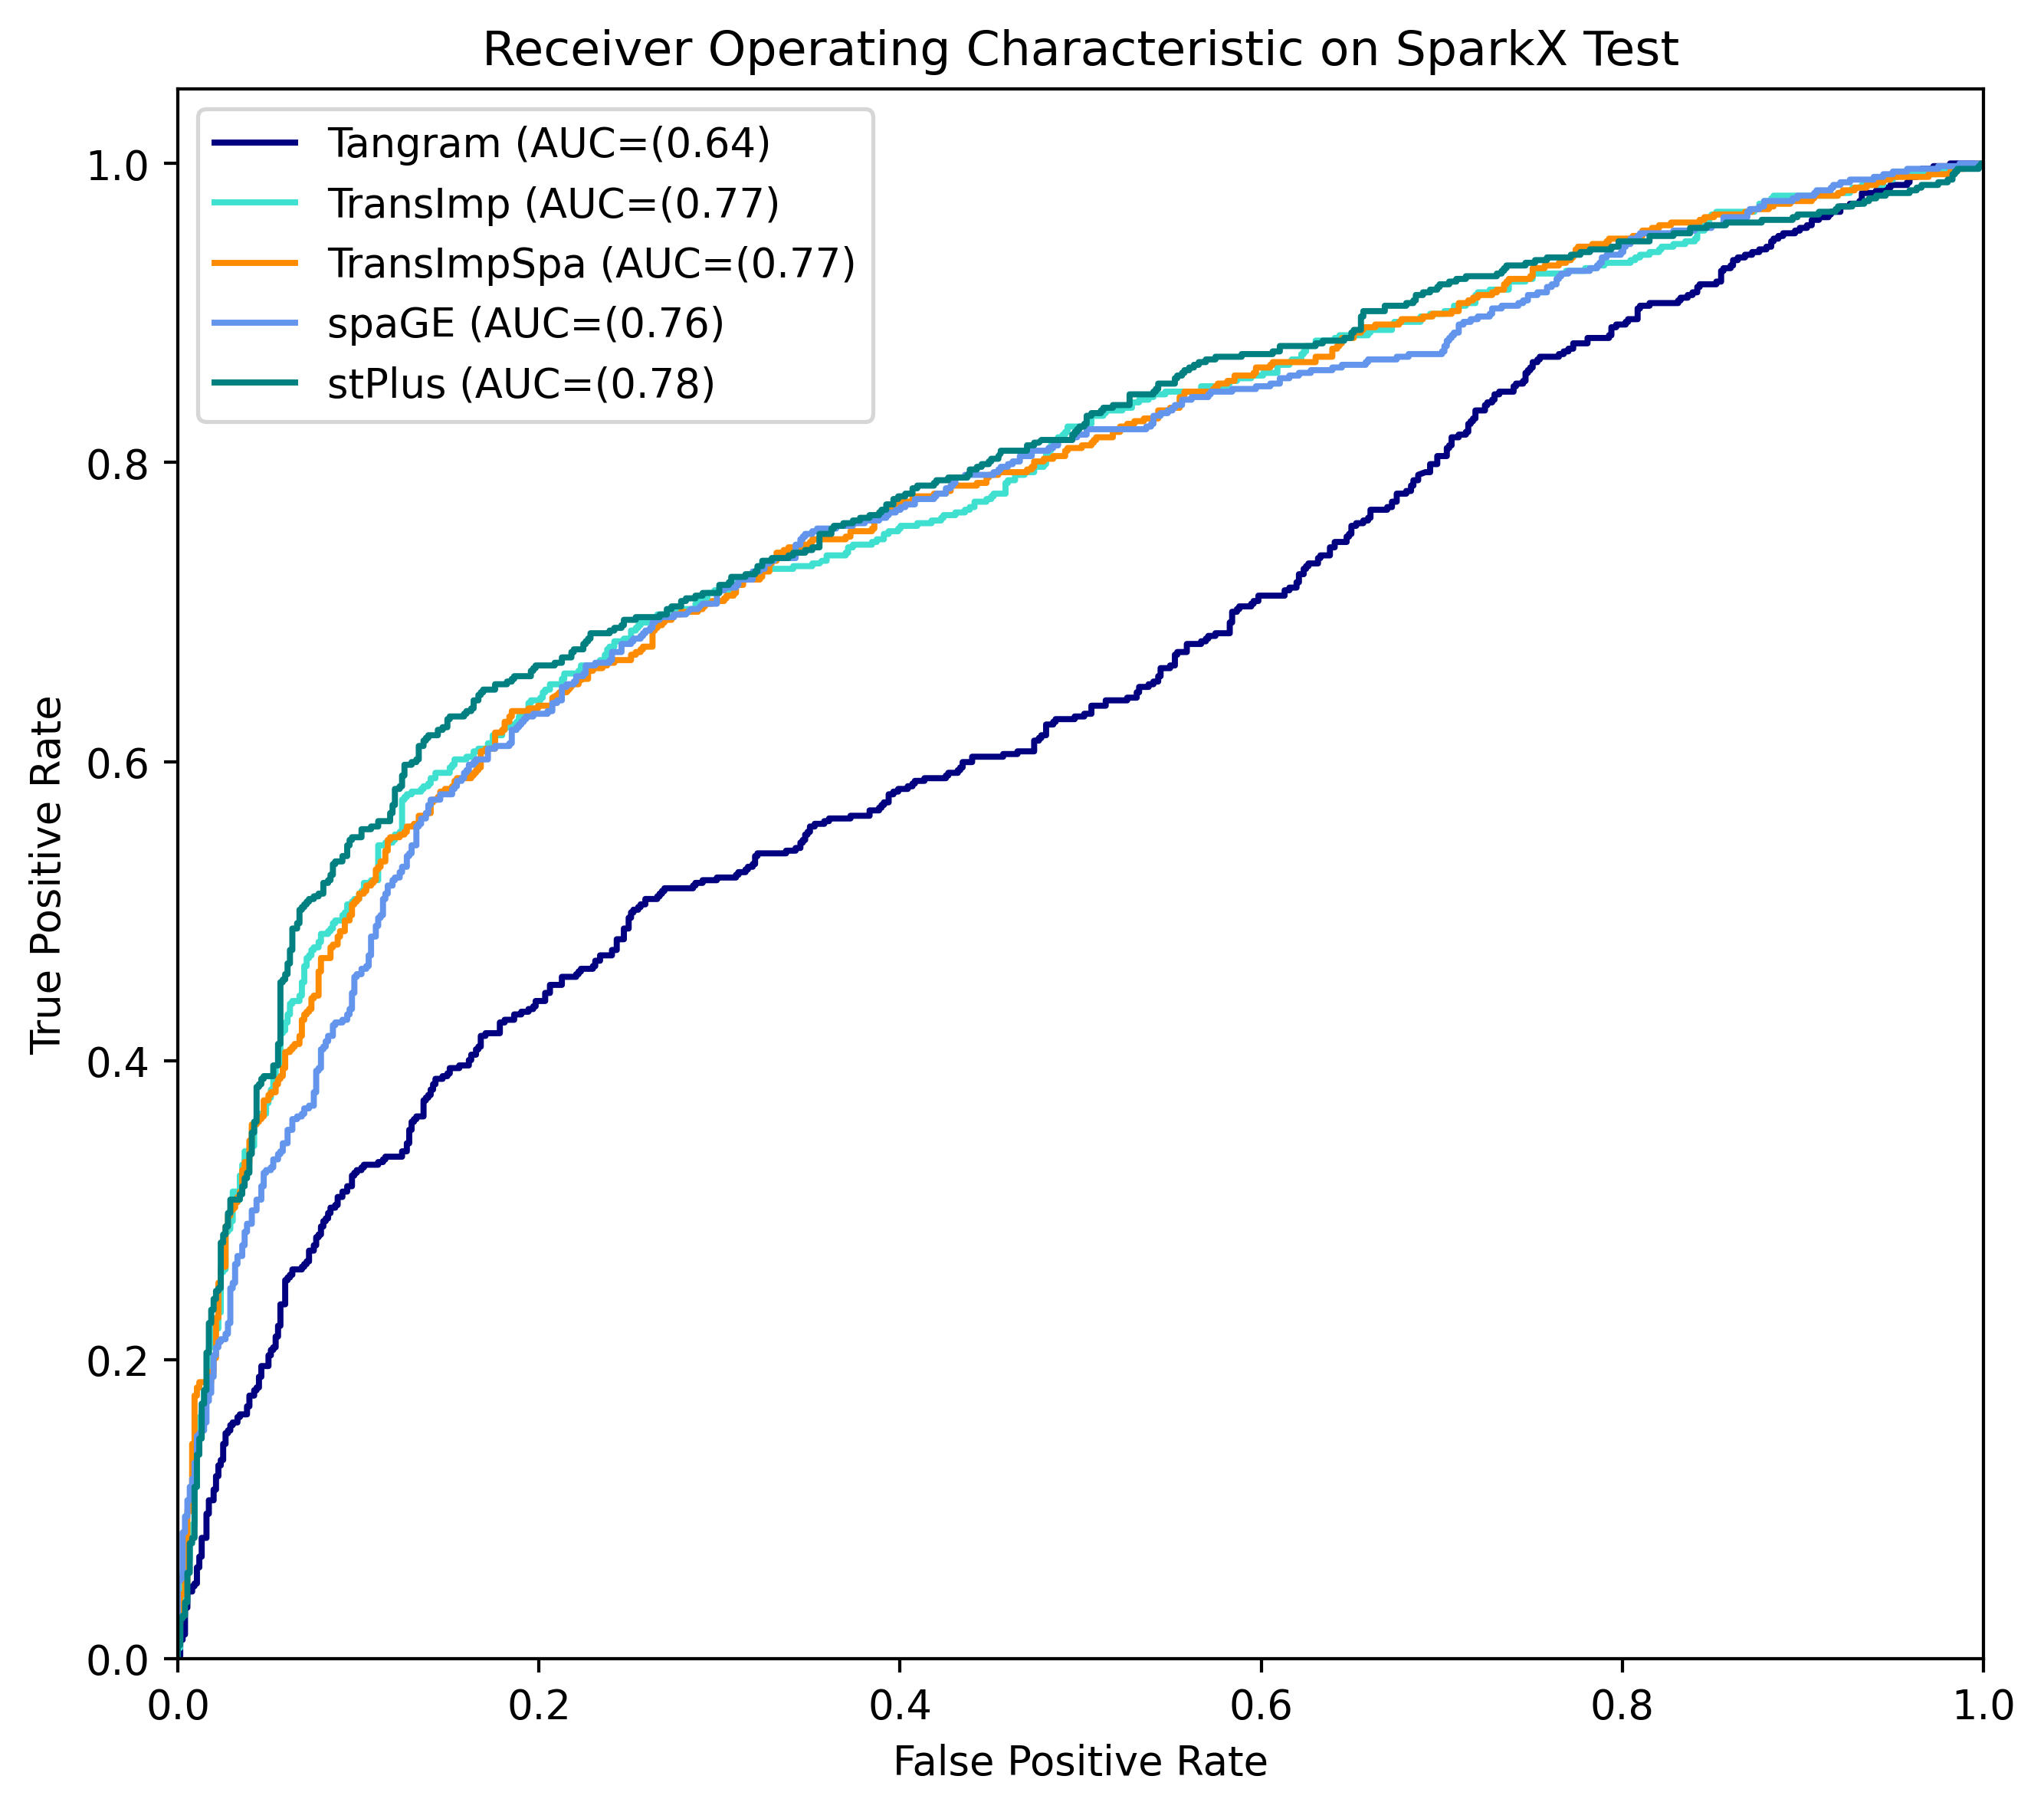

In [25]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_adjpvals[method][sel].values
    score = -np.log(df_sparkx_cmbpvals[method][sel].values + 1e-100)
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 1314/1314
Tangram
FPR: 0.923382
prec: 0.43629032258064515, recl: 0.9712746858168761,  F1: 0.6021146355036171
(TransImp) Valid genes: 1314/1314
TransImp
FPR: 0.737120
prec: 0.4789915966386555, recl: 0.9210053859964094,  F1: 0.6302211302211302
(TransImpCls) Valid genes: 1314/1314
TransImpCls
FPR: 0.774108
prec: 0.4663023679417122, recl: 0.9192100538599641,  F1: 0.6187311178247734
(TransImpClsSpa) Valid genes: 1314/1314
TransImpClsSpa
FPR: 0.669749
prec: 0.493, recl: 0.8850987432675045,  F1: 0.6332691072575465
(TransImpSpa) Valid genes: 1314/1314
TransImpSpa
FPR: 0.659181
prec: 0.4984924623115578, recl: 0.8904847396768402,  F1: 0.6391752577319587
(spaGE) Valid genes: 1314/1314
spaGE
FPR: 0.701453
prec: 0.47941176470588237, recl: 0.8779174147217235,  F1: 0.6201648700063411
(stPlus) Valid genes: 1314/1314
stPlus
FPR: 0.805812
prec: 0.46397188049209137, recl: 0.947935368043088,  F1: 0.6230088495575221


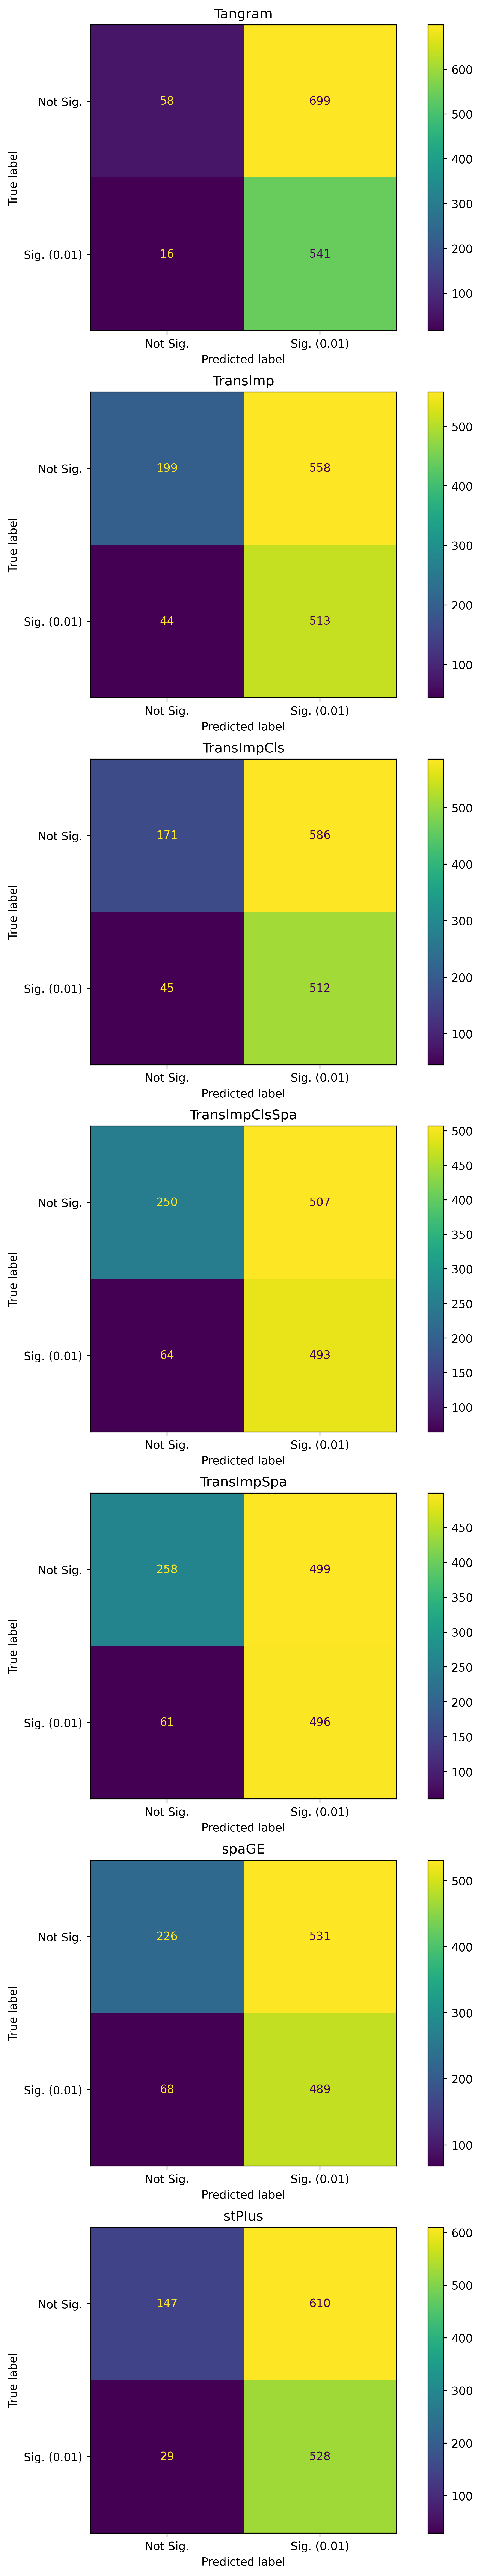

In [26]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()